# Contents of this Notebook
• Quick look at some images in the dataset

• Download a few categories of shape positives and some categories to distinguish those from

• Download the classification text file

• Set some core variables needed throughout

• Load flattened arrays (N, 784) → reshape to (N, 28, 28)

• Organise data into X and y

• Define and compile the model

• Test train split

• Training

• Preview, graphs, refinement

• Saving the model and converting it into a javascript model (tensorflowjs) via terminal commands



In [1]:
from quickdraw import QuickDrawDataGroup
from IPython.display import display
import os, urllib.request
import requests
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json, pathlib
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
np.random.seed(42)

loading circle drawings
load complete


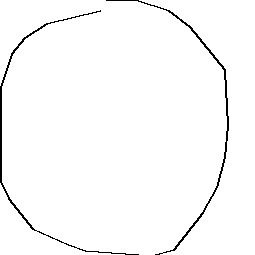

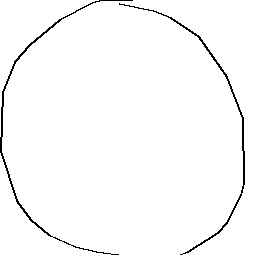

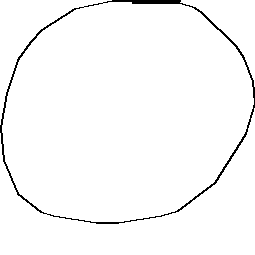

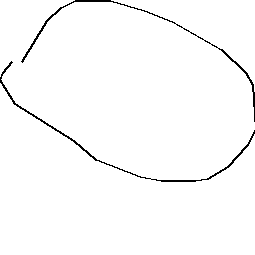

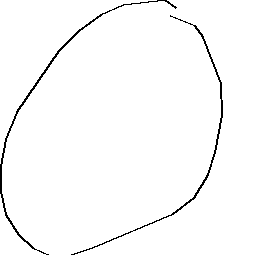

In [3]:
circle_group = QuickDrawDataGroup("circle", max_drawings=10000)

for _ in range(5):
    d = circle_group.get_drawing()
    display(d.image)

In [4]:
DATA_DIR = "data/quickdraw_npy"  # where your .npy files are

TARGETS = ["circle", "square", "triangle", "star"]  # no "arrow"
OTHERS  = ["face", "cat", "cloud", "house", "tree", "zigzag"]

CLASS_NAMES = TARGETS + ["other"]
CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}

In [5]:

os.makedirs(DATA_DIR, exist_ok=True) #make the data directory if you don't have it on your machine

classes = ["circle", "square", "triangle", "star", "face", "cat", "cloud", "house", "tree", "zigzag"]

base = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap"

for c in classes:
    url = f"{base}/{c}.npy"
    dst = os.path.join(DATA_DIR, f"{c}.npy")
    if not os.path.exists(dst):
        print("downloading", url)
        urllib.request.urlretrieve(url, dst)
print("done")

downloading https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/zigzag.npy
done


# 1. About the data - What Google did with QuickDraw

Each QuickDraw doodle was drawn by a person as a sequence of strokes (vector data).

Google rasterised those strokes into 28 × 28 pixel images, grayscale.

Each pixel is **grayscale** — it holds an intensity value from 0 to 255 (0 = black, 255 = white, or sometimes inverted depending on convention).

To make the dataset compact, they then flattened each 28×28 image into a 1D vector of length 784 (because 28 × 28 = 784).

In [6]:
def load_npy(path, limit=None):
    """
    Quick, Draw! numpy_bitmap .npy: shape (N, 784) uint8.
    Returns (N, 28, 28) uint8.
    """
    arr = np.load(path)                 # (N, 784) uint8
    if limit is not None:
        arr = arr[:limit]
    return arr.reshape(-1, 28, 28)      # -> (N,28,28)

# Logic of the data distribution in the model
Some false positive classes were included to train the model - it needs to learn not only to recognise circles and squares but also to disregard random stuff. The random stuff included in this model is:

 "face", "cat", "cloud", "house", "tree"

 But this could be increased to make a better model.

 Below the function therefore deals with both of those.


# What the function returns

X: all images, normalised to [0,1] and shaped (N, 28, 28, 1) (float32).

y: one integer label per image, shaped (N,) (int64). Uses your CLASS_TO_ID mapping.

In [7]:
def build_arrays(data_dir, per_class=5000, other_total=5000, seed=0):
    rng = np.random.default_rng(seed)  # for a reproducible final shuffle

    Xs, ys = [], []  # we collect per-class arrays here (features X, labels y)

    # 1) TARGET classes: circle/square/triangle/star
    for cname in TARGETS:
        Xc = load_npy(os.path.join(data_dir, f"{cname}.npy"), per_class)
        # Xc: (per_class, 28, 28) uint8 — the images for this target class
        yc = np.full(len(Xc), CLASS_TO_ID[cname], dtype=np.int64)
        # yc: (per_class,) int64 — the labels for this class, all the same id
        Xs.append(Xc)
        ys.append(yc)

    # 2) "OTHER" bucket: pool several categories into one label
    per_other = max(1, other_total // len(OTHERS))  # try to sample evenly
    other_parts = []
    for cname in OTHERS:
        Xo_part = load_npy(os.path.join(data_dir, f"{cname}.npy"), per_other)
        other_parts.append(Xo_part)
    Xo = np.concatenate(other_parts, axis=0)             # (~other_total, 28, 28)
    yo = np.full(len(Xo), CLASS_TO_ID["other"], dtype=np.int64)  # same id for all

    # 3) Concatenate everything into single feature/label arrays
    X = np.concatenate(Xs + [Xo], axis=0)  # (N, 28, 28) uint8
    y = np.concatenate(ys + [yo], axis=0)  # (N,)        int64

    # 4) Normalise & add channel dim for Keras (channels-last)
    X = (X.astype("float32") / 255.0)[..., None]  # (N, 28, 28, 1) float32

    # 5) Final shuffle to mix classes so batches aren’t blocky
    idx = rng.permutation(len(X))
    return X[idx], y[idx]


In [9]:
X, y = build_arrays(DATA_DIR, per_class=4500, other_total=4500)  # ~15k total
X.shape, y.shape, np.bincount(y)
# Expect: ((~15000, 28, 28, 1), (~15000,), counts per class)

((22500, 28, 28, 1), (22500,), array([4500, 4500, 4500, 4500, 4500]))

In [ ]:
n_classes = len(CLASS_NAMES)

# 1) the clean model (this is the one you’ll export / use later)
model = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),                  # 28→14
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),                  # 14→7
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
], name="classifier")

# 2) augmentation pipeline
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15, fill_mode="constant", fill_value=0.0),
], name="aug")

# 3) training model = aug + model
train_model = models.Sequential([
    layers.Input(shape=(28,28,1)),
    data_augmentation,
    model
], name="train_model")

train_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

train_model.summary()


Model: "train_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 aug (Sequential)            (None, 28, 28, 1)         0         
                                                                 
 classifier (Sequential)     (None, 5)                 105541    
                                                                 
Total params: 105541 (412.27 KB)
Trainable params: 105541 (412.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

es = EarlyStopping(patience=5, restore_best_weights=True)

# 4) fit with train_model
history = train_model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=10, batch_size=256, verbose=1, callbacks=[es]
)

# # 5) when exporting: save only the clean classifier
# model.save("shapes_tinycnn_keras.h5")

Epoch 1/10
80/80 [==============================] - 2s 22ms/step - loss: 0.7926 - accuracy: 0.7094 - val_loss: 0.5515 - val_accuracy: 0.8164
Epoch 2/10
80/80 [==============================] - 2s 20ms/step - loss: 0.4596 - accuracy: 0.8532 - val_loss: 0.4134 - val_accuracy: 0.8600
Epoch 3/10
80/80 [==============================] - 2s 20ms/step - loss: 0.3823 - accuracy: 0.8777 - val_loss: 0.3640 - val_accuracy: 0.8778
Epoch 4/10
80/80 [==============================] - 2s 20ms/step - loss: 0.3507 - accuracy: 0.8883 - val_loss: 0.3481 - val_accuracy: 0.8809
Epoch 5/10
80/80 [==============================] - 2s 20ms/step - loss: 0.3283 - accuracy: 0.8967 - val_loss: 0.3173 - val_accuracy: 0.8916
Epoch 6/10
80/80 [==============================] - 2s 20ms/step - loss: 0.3202 - accuracy: 0.8973 - val_loss: 0.3016 - val_accuracy: 0.9013
Epoch 7/10
80/80 [==============================] - 2s 20ms/step - loss: 0.3042 - accuracy: 0.9037 - val_loss: 0.3000 - val_accuracy: 0.9044
Epoch 8/10
80

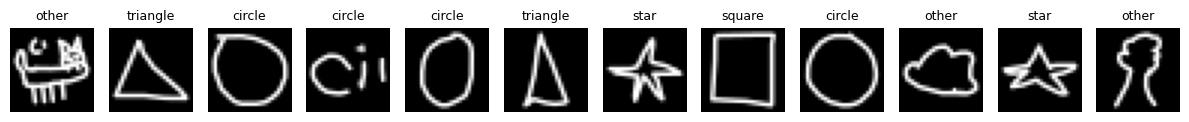

In [12]:
def show_grid(X, y, n=10):
    plt.figure(figsize=(12,2))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(X[i,...,0], cmap="gray")
        plt.title(CLASS_NAMES[y[i]], fontsize=9)
        plt.axis("off")
    plt.tight_layout(); plt.show()

show_grid(Xtr, ytr, n=12)


              precision    recall  f1-score   support

      circle      0.957     0.929     0.943       450
      square      0.962     0.902     0.931       450
    triangle      0.940     0.940     0.940       450
        star      0.885     0.938     0.910       450
       other      0.830     0.856     0.842       450

    accuracy                          0.913      2250
   macro avg      0.915     0.913     0.913      2250
weighted avg      0.915     0.913     0.913      2250



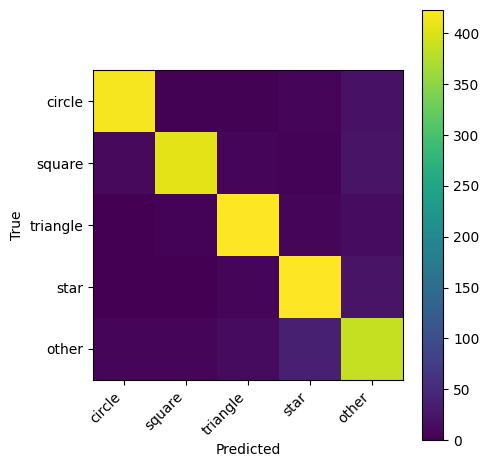

In [14]:
# predictions on validation set
proba = model.predict(Xva, verbose=0)
yhat  = proba.argmax(axis=1)

print(classification_report(yva, yhat, target_names=CLASS_NAMES, digits=3))

# confusion matrix (vanilla matplotlib)
cm = confusion_matrix(yva, yhat, labels=range(len(CLASS_NAMES)))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(CLASS_NAMES))); ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()


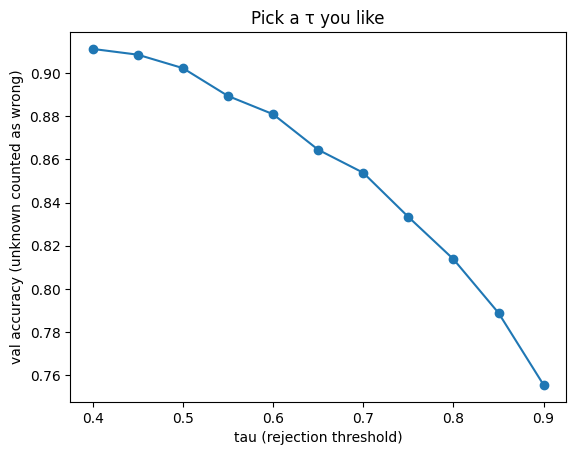

In [15]:
def predict_with_reject(Xb, tau=0.6):
    proba = model.predict(Xb, verbose=0)
    maxp  = proba.max(axis=1)
    arg   = proba.argmax(axis=1)
    labels = np.where(maxp < tau, -1, arg)  # -1 = unknown
    return labels, maxp, proba

# sweep τ to see trade-off
taus = np.linspace(0.4, 0.9, 11)
accs = []
for t in taus:
    labels, _, _ = predict_with_reject(Xva, tau=t)
    # treat unknown as wrong for this simple score
    ok = (labels == yva)
    accs.append(ok.mean())

plt.figure(); plt.plot(taus, accs, marker="o")
plt.xlabel("tau (rejection threshold)"); plt.ylabel("val accuracy (unknown counted as wrong)")
plt.title("Pick a τ you like"); plt.show()


In [16]:
# pick a few that weren't in TARGETS or OTHERS
UNSEEN = ["airplane","banana","bus","chair"]
unseen_batch = []
for c in UNSEEN:
    path = os.path.join(DATA_DIR, f"{c}.npy")
    if os.path.exists(path):
        arr = np.load(path)[:200].reshape(-1,28,28,1).astype("float32")/255.0
        unseen_batch.append(arr)
if unseen_batch:
    X_unseen = np.concatenate(unseen_batch, axis=0)
    labels, maxp, _ = predict_with_reject(X_unseen, tau=0.6)
    unknown_rate = (labels==-1).mean()
    print(f"Unknown rate on unseen classes: {unknown_rate:.2%} (want this fairly high)")

In [17]:

def predict_one(img28, tau=0.6, mdl=model, classes=CLASS_NAMES):
    x = img28.astype("float32")
    if x.max() > 1.0:
        x = x / 255.0
    x = x[None, ..., None]
    proba = mdl.predict(x, verbose=0)[0]
    i = proba.argmax()
    return ("unknown", float(proba[i])) if proba[i] < tau else (classes[i], float(proba[i]))


# demo on a val sample
lbl, conf = predict_one((Xva[0,...,0]*255).astype("uint8"), tau=0.6)
lbl, conf, "true:", CLASS_NAMES[yva[0]]

('circle', 0.9992730021476746, 'true:', 'circle')

In [18]:
# jitter the training images by ±1 pixel
def jitter_shift(x):
    dy = np.random.randint(-1, 2)
    dx = np.random.randint(-1, 2)
    return np.roll(np.roll(x, dy, axis=0), dx, axis=1)

aug_X = Xtr.copy()
mask = np.random.rand(len(aug_X)) < 0.5
aug_X[mask,...,0] = np.array([jitter_shift(im) for im in aug_X[mask,...,0]])

history = train_model.fit(aug_X, ytr, validation_data=(Xva, yva),
                    epochs=3, batch_size=256, verbose=1)


Epoch 1/3
80/80 [==============================] - 2s 20ms/step - loss: 0.2776 - accuracy: 0.9129 - val_loss: 0.2710 - val_accuracy: 0.9111
Epoch 2/3
80/80 [==============================] - 2s 20ms/step - loss: 0.2667 - accuracy: 0.9147 - val_loss: 0.2543 - val_accuracy: 0.9133
Epoch 3/3
80/80 [==============================] - 2s 20ms/step - loss: 0.2564 - accuracy: 0.9180 - val_loss: 0.2589 - val_accuracy: 0.9262


In [19]:
CLASS_NAMES

['circle', 'square', 'triangle', 'star', 'other']

In [20]:
model.save("shapes_tinycnn_keras.h5")

/Users/artf/.pyenv/versions/3.10.6/envs/doodle-autocomplete/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
#  Now go to terminal to make a js model
#
#  tensorflowjs_converter --input_format=keras \
#  notebooks/louise_notebooks/shapes_tinycnn_keras.h5 \
#  web_model/